## Yago semantic graph 
Usecase - find inconsistencies / anomalies in knowledge graphs

## FB15k-237 semantic graph

https://www.kaggle.com/datasets/latebloomer/fb15k-237/data

https://www.kaggle.com/datasets/latebloomer/freebase-wikidata-mapping

In [1]:
!pip install kagglehub

In [3]:
import kagglehub

# path = kagglehub.dataset_download("latebloomer/fb15k-237")
# print("Path to dataset files:", path)

100%|████████████████████████████████████████████████████████████████████████████████| 3.63M/3.63M [00:00<00:00, 26.4MB/s]

Extracting files...
Path to dataset files: /Users/ravid/.cache/kagglehub/datasets/latebloomer/fb15k-237/versions/1


In [5]:
import pandas as pd

In [4]:
data_path = "../datasets/fb15k-237/"

In [21]:
column_names = ['src', 'relation', 'dst']
triples_df = pd.read_csv(f"{data_path}/train.txt", header=None, names=column_names)
# df = pd.read_csv(f"{data_path}/train.txt", sep='/t', header=None, names=column_names)

In [22]:
triples_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272115 entries, 0 to 272114
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   src       272115 non-null  object
 1   relation  272115 non-null  object
 2   dst       272115 non-null  object
dtypes: object(3)
memory usage: 6.2+ MB


In [23]:
triples_df.head(5)

,src,relation,dst
0,/m/027rn,/location/country/form_of_government,/m/06cx9
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0
2,/m/07s9rl0,/media_common/netflix_genre/titles,/m/0170z3
3,/m/01sl1q,/award/award_winner/awards_won./award/award_ho...,/m/044mz_
4,/m/0cnk2q,/soccer/football_team/current_roster./sports/s...,/m/02nzb8


In [25]:
freebase_vs_wiki_df =  pd.read_csv(f"{data_path}/fb_wiki_mapping.tsv", sep='\t')
# freebase_vs_wiki_df =  pd.read_csv(f"{data_path}/fb_wiki_mapping.csv")

In [26]:
freebase_vs_wiki_df.head(3)

,freebase_id,wikidata_id,label
0,/m/010005,Q974334,Corinth
1,/m/01000j,Q981582,Draper
2,/m/01000w,Q977417,Cross Roads


In [ ]:
# All nodes and associated triples for freebase / wiki ?


In [17]:
import kumoai.experimental.rfm as rfm

In [18]:
import os

if not os.environ.get("KUMO_API_KEY"):
    rfm.authenticate()

Opening browser page to automatically generate an API key...


[2025-08-17 11:53:50 - kumoai:298 - INFO] Generated token "sdk-macbook-pro-3.local-2025-08-17-11-53-48-Z" and saved to KUMO_API_KEY env variable


In [20]:
KUMO_API_KEY = os.environ.get("KUMO_API_KEY")
rfm.init(api_key=KUMO_API_KEY)

[2025-08-17 11:58:55 - kumoai:196 - INFO] Successfully initialized the Kumo SDK against deployment https://kumorfm.ai/api, with log level INFO.


In [24]:
triples = rfm.LocalTable(triples_df, name="triples").infer_metadata()

In [29]:
freebase_vs_wiki = rfm.LocalTable(freebase_vs_wiki_df, name="freebase_vs_wiki", primary_key="freebase_id").infer_metadata()

In [30]:
graph = rfm.LocalGraph(tables=[
    triples,
    freebase_vs_wiki,
])

In [31]:
graph.link(src_table="triples", fkey="src", dst_table="freebase_vs_wiki")

LocalGraph(
  tables=[triples, freebase_vs_wiki],
  edges=[Edge(src_table='triples', fkey='src', dst_table='freebase_vs_wiki')],
)

In [32]:
graph.link(src_table="triples", fkey="dst", dst_table="freebase_vs_wiki")

LocalGraph(
  tables=[triples, freebase_vs_wiki],
  edges=[Edge(src_table='triples', fkey='src', dst_table='freebase_vs_wiki'), Edge(src_table='triples', fkey='dst', dst_table='freebase_vs_wiki')],
)

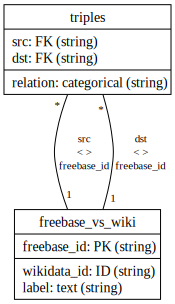

In [33]:
graph.visualize();

In [ ]:
query = "PREDICT SUM(orders.price, 0, 30, days) FOR items.item_id=42"

df = model.predict(query)
display(df)